In [1]:
import pandas as pd #Baca & Olah dataset Csv
import numpy as np #Perhitungan matematis
import matplotlib.pyplot as plt #visualisasi grafik
import skfuzzy as fuzz #library utama untuk fuzzy logic
from skfuzzy import control as ctrl
print('Libraries imported')


Libraries imported


In [2]:
# Load dataset (expects Pune_House_Data.csv in same directory)
df = pd.read_csv('Pune_House_Data.csv')
print('Dataset loaded. Shape:', df.shape)
df.head()

Dataset loaded. Shape: (13320, 9)


,area_type,availability,size,society,total_sqft,bath,balcony,price,site_location
0,Super built-up Area,19-Dec,2 BHK,Coomee,1056,2.0,1.0,39.07,Alandi Road
1,Plot Area,Ready To Move,4 Bedroom,Theanmp,2600,5.0,3.0,120.00,Ambegaon Budruk
2,Built-up Area,Ready To Move,3 BHK,NaN,1440,2.0,3.0,62.00,Anandnagar
3,Super built-up Area,Ready To Move,3 BHK,Soiewre,1521,3.0,1.0,95.00,Aundh
4,Super built-up Area,Ready To Move,2 BHK,NaN,1200,2.0,1.0,51.00,Aundh Road


In [5]:

# --- 1️⃣ Ubah kolom agar cocok ---
# Ambil kolom yang dibutuhkan
df = df[['total_sqft', 'size', 'price']].copy()

# Rename biar konsisten dengan model fuzzy kita
df.columns = ['Area', 'Bedrooms', 'Price']

# --- 2️⃣ Bersihkan data 'Bedrooms' (ubah dari '2 BHK' ke angka 2) ---
df['Bedrooms'] = df['Bedrooms'].str.extract('(\d+)').astype(float)

# --- 3️⃣ Bersihkan data 'Area' (ubah range seperti "1200 - 1500" jadi rata-rata) ---
def convert_sqft(value):
    try:
        if '-' in value:
            low, high = value.split('-')
            return (float(low) + float(high)) / 2
        else:
            return float(value)
    except:
        return None

df['Area'] = df['Area'].apply(convert_sqft)

# --- 4️⃣ Hapus data kosong atau aneh ---
df = df.dropna(subset=['Area', 'Bedrooms', 'Price'])
df = df[(df['Area'] > 0) & (df['Bedrooms'] > 0) & (df['Price'] > 0)].reset_index(drop=True)

print('✅ Dataset cleaned! Shape:', df.shape)
print(df.head())



✅ Dataset cleaned! Shape: (13258, 3)
     Area  Bedrooms   Price
0  1056.0       2.0   39.07
1  2600.0       4.0  120.00
2  1440.0       3.0   62.00
3  1521.0       3.0   95.00
4  1200.0       2.0   51.00


In [6]:
# Create fuzzy variables ranges based on observed data
area_min, area_max = df['Area'].min(), df['Area'].max()
bed_min, bed_max = df['Bedrooms'].min(), df['Bedrooms'].max()
price_min, price_max = df['Price'].min(), df['Price'].max()
print(f'Area range: {area_min} - {area_max}')
print(f'Bedrooms range: {bed_min} - {bed_max}')
print(f'Price range: {price_min} - {price_max}')

# Extend ranges slightly to allow membership tails
area_range = np.linspace(area_min*0.9, area_max*1.1, 100)
bed_range = np.linspace(max(0, bed_min-1), bed_max+1, 100)
price_range = np.linspace(price_min*0.9, price_max*1.1, 100)

# Define fuzzy Antecedents and Consequent
area = ctrl.Antecedent(area_range, 'area')
bedrooms = ctrl.Antecedent(bed_range, 'bedrooms')
price = ctrl.Consequent(price_range, 'price')

# Membership functions for area: small, medium, large
area['small'] = fuzz.trimf(area.universe, [area_range[0], area_range[0], np.percentile(df['Area'], 33)])
area['medium'] = fuzz.trimf(area.universe, [np.percentile(df['Area'], 25), np.median(df['Area']), np.percentile(df['Area'], 75)])
area['large'] = fuzz.trimf(area.universe, [np.percentile(df['Area'], 66), area_range[-1], area_range[-1]])

# Membership functions for bedrooms: few, average, many
bedrooms['few'] = fuzz.trimf(bedrooms.universe, [bed_range[0], bed_range[0], np.percentile(df['Bedrooms'], 33)])
bedrooms['average'] = fuzz.trimf(bedrooms.universe, [np.percentile(df['Bedrooms'], 25), np.median(df['Bedrooms']), np.percentile(df['Bedrooms'], 75)])
bedrooms['many'] = fuzz.trimf(bedrooms.universe, [np.percentile(df['Bedrooms'], 66), bed_range[-1], bed_range[-1]])

# Membership functions for price: cheap, medium, expensive
price['cheap'] = fuzz.trimf(price.universe, [price_range[0], price_range[0], np.percentile(df['Price'], 33)])
price['medium'] = fuzz.trimf(price.universe, [np.percentile(df['Price'], 25), np.median(df['Price']), np.percentile(df['Price'], 75)])
price['expensive'] = fuzz.trimf(price.universe, [np.percentile(df['Price'], 66), price_range[-1], price_range[-1]])

print('Fuzzy variables and membership functions created')


Area range: 1.0 - 52272.0
Bedrooms range: 1.0 - 43.0
Price range: 8.0 - 3600.0
Fuzzy variables and membership functions created


C:\Users\hp\anaconda3\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


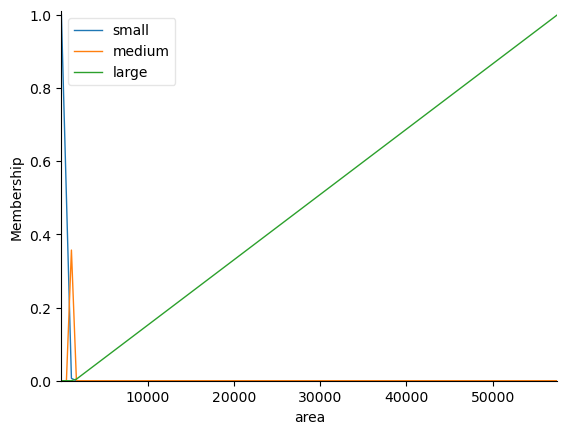

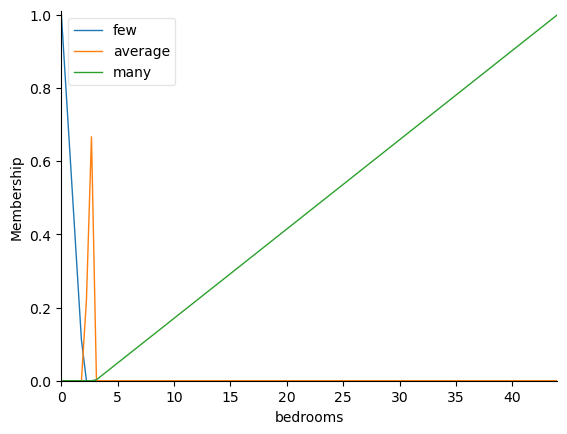

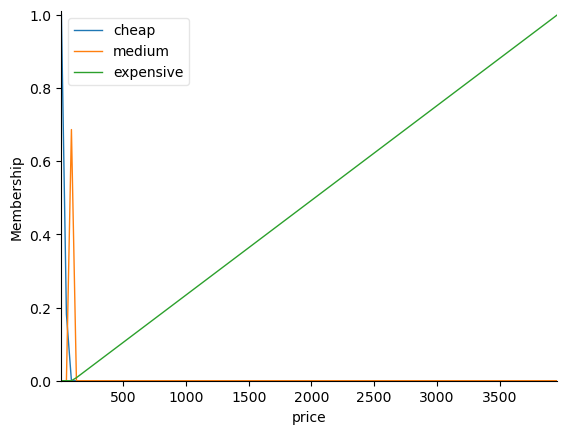

In [7]:
area.view()
bedrooms.view()
price.view()


In [8]:
# Define rules (examples). You can expand or refine these rules.
rule1 = ctrl.Rule(area['large'] & bedrooms['many'], price['expensive'])
rule2 = ctrl.Rule(area['small'] & bedrooms['few'], price['cheap'])
rule3 = ctrl.Rule(area['medium'] & bedrooms['average'], price['medium'])
rule4 = ctrl.Rule(area['large'] & bedrooms['average'], price['expensive'])
rule5 = ctrl.Rule(area['small'] & bedrooms['many'], price['medium'])

pricing_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])
pricing = ctrl.ControlSystemSimulation(pricing_ctrl)
print('Fuzzy rules and control system ready')

Fuzzy rules and control system ready


In [9]:
def compute_fuzzy(row):
    pricing.input['area'] = row['Area']
    pricing.input['bedrooms'] = row['Bedrooms']
    try:
        pricing.compute()
        out = pricing.output['price']
    except Exception as e:
        # In case of numerical issues fallback to median
        out = np.median(df['Price'])
    return out

# Apply to dataframe (this may be slow for very large datasets)
df['Fuzzy_Score'] = df.apply(compute_fuzzy, axis=1)
print('Fuzzy score computed for all rows')
df[['Area','Bedrooms','Price','Fuzzy_Score']].head()


Fuzzy score computed for all rows


,Area,Bedrooms,Price,Fuzzy_Score
0,1056.0,2.0,39.07,73.822257
1,2600.0,4.0,120.00,2045.567969
2,1440.0,3.0,62.00,878.864777
3,1521.0,3.0,95.00,1086.830094
4,1200.0,2.0,51.00,307.203304


In [10]:
# Normalize Fuzzy_Score to 0-100
min_score, max_score = df['Fuzzy_Score'].min(), df['Fuzzy_Score'].max()
df['Fuzzy_Score_Norm'] = (df['Fuzzy_Score'] - min_score) / (max_score - min_score) * 100

def categorize(score):
    if score <= 33:
        return 'Cheap'
    elif score <= 66:
        return 'Medium'
    else:
        return 'Expensive'

df['Price_Category'] = df['Fuzzy_Score_Norm'].apply(categorize)
df[['Area','Bedrooms','Price','Fuzzy_Score_Norm','Price_Category']].head()


,Area,Bedrooms,Price,Fuzzy_Score_Norm,Price_Category
0,1056.0,2.0,39.07,1.979084,Cheap
1,2600.0,4.0,120.00,93.429920,Expensive
2,1440.0,3.0,62.00,39.317475,Medium
3,1521.0,3.0,95.00,48.963040,Medium
4,1200.0,2.0,51.00,12.803448,Cheap


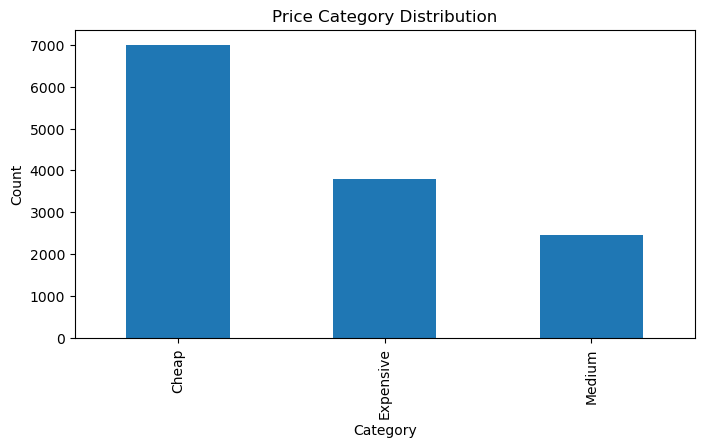

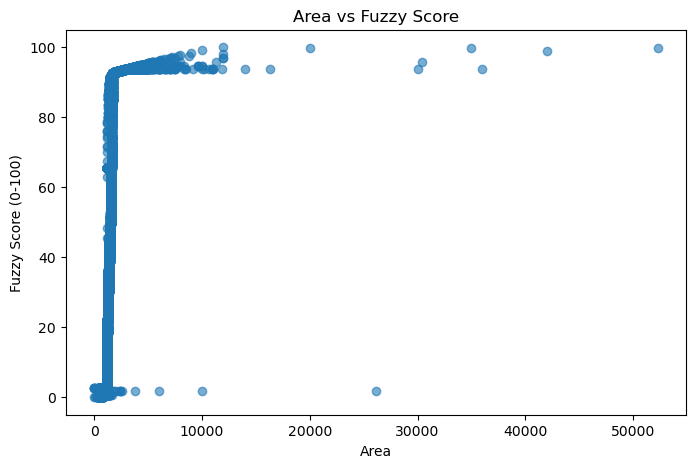

In [11]:
plt.figure(figsize=(8,4))
df['Price_Category'].value_counts().plot(kind='bar')
plt.title('Price Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8,5))
plt.scatter(df['Area'], df['Fuzzy_Score_Norm'], alpha=0.6)
plt.xlabel('Area')
plt.ylabel('Fuzzy Score (0-100)')
plt.title('Area vs Fuzzy Score')
plt.show()
